In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
import emlearn

# --- CONFIGURAZIONE TINYML ---
MAX_POWER = 10.0    # kW (Massima potenza impianto/contatore)
MAX_IRR = 1200.0    # W/m2 (Massima irradianza fisica)
MAX_TEMP = 50.0     # °C (Massima temperatura ambiente)

SEQ_LENGTH = 10     # Ultimi 10 ore di storico da guardare

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.20.0


In [ ]:
# 1. CARICAMENTO E PREPARAZIONE
df = pd.read_csv("personal-dataset.csv")

# Conversione Temporale robusta (gestisce timezone e errori)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True, errors='coerce')
df.sort_values('Timestamp', inplace=True)

# Feature Engineering per Embedded
df['day_norm'] = df['Timestamp'].dt.dayofweek / 6.0  # 0=Lun, 1=Dom
df['hour_norm'] = df['Timestamp'].dt.hour / 23.0     # 0-23 -> 0-1

# Normalizzazione "Hardware Friendly"
df['PV_norm'] = df['P_PV_kW'] / MAX_POWER
df['Load_norm'] = df['P_Load_kW'] / MAX_POWER
df['Irr_norm'] = df['IRRADIATION'] / MAX_IRR
df['Temp_norm'] = df['TEMPERATURE'] / MAX_TEMP

# Clip per sicurezza (evita valori > 1.0 se i sensori sballano)
cols = ['PV_norm', 'Load_norm', 'Irr_norm', 'Temp_norm']
df[cols] = df[cols].clip(0, 1)

print(f"Dati pronti: {len(df)} ore")
print(f"PV_norm: min={df['PV_norm'].min():.3f}, max={df['PV_norm'].max():.3f}, media={df['PV_norm'].mean():.3f}")
print(f"Load_norm: min={df['Load_norm'].min():.3f}, max={df['Load_norm'].max():.3f}, media={df['Load_norm'].mean():.3f}")
df.head()

Dati pronti: 3858 ore
PV_norm: min=0.000, max=0.514, media=0.046
Load_norm: min=0.019, max=0.393, media=0.057


,Timestamp,P_PV_kW,P_Load_kW,TEMPERATURE,IRRADIATION,hour_norm,day_norm,PV_norm,Load_norm,Irr_norm,Temp_norm
0,2025-07-01 01:00:00+00:00,0.000,1.338,24.3,0.0,0.043478,0.166667,0.0000,0.1338,0.000000,0.486
1,2025-07-01 02:00:00+00:00,0.000,1.305,23.5,0.0,0.086957,0.166667,0.0000,0.1305,0.000000,0.470
2,2025-07-01 03:00:00+00:00,0.000,1.146,22.9,0.0,0.130435,0.166667,0.0000,0.1146,0.000000,0.458
3,2025-07-01 04:00:00+00:00,0.000,1.018,22.4,0.0,0.173913,0.166667,0.0000,0.1018,0.000000,0.448
4,2025-07-01 05:00:00+00:00,0.003,1.002,21.9,2.0,0.217391,0.166667,0.0003,0.1002,0.001667,0.438


In [ ]:
# 2. GENERAZIONE SEQUENZE (SLIDING WINDOW)
def make_dataset_multi(data, seq_len=10):
    """
    Crea sequenze temporali per predizione multi-output
    Input: ultimi seq_len timesteps di misurazioni [Irr, Temp, hour, day, PV, Load]
    Output: [PV_futuro, Load_futuro] al timestep successivo
    """
    X, y = [], []
    for i in range(len(data) - seq_len):
        # Input: sequenza di 10 misurazioni passate
        X.append(data[i : i+seq_len])
        # Target: [PV_norm, Load_norm] alla prossima ora
        # Indici: 0=Irr, 1=Temp, 2=hour, 3=day, 4=PV, 5=Load
        y.append(data[i+seq_len, [4, 5]])  # 4=PV_norm, 5=Load_norm
    return np.array(X), np.array(y)

# --- DATASET UNICO ---
# Input: tutte le feature normalizzate + engineered
# Target: [PV_norm, Load_norm] (prossima ora)
cols_all = ['Irr_norm', 'Temp_norm', 'hour_norm', 'day_norm', 'PV_norm', 'Load_norm']
data_all = df[cols_all].values

print(f"Feature ordine: {cols_all}")
print(f"  0=Irr_norm, 1=Temp_norm, 2=hour_norm, 3=day_norm, 4=PV_norm, 5=Load_norm")

X_all, y_all = make_dataset_multi(data_all, seq_len=SEQ_LENGTH)
X_all = X_all.reshape(X_all.shape[0], -1) # Flattening (10*6 = 60 input)

print(f"\nInput Shape: {X_all.shape}  (campioni, {SEQ_LENGTH}*6 features)")
print(f"Output Shape: {y_all.shape}  (campioni, 2 outputs: PV e Load)")
print(f"\nOgni predizione usa {SEQ_LENGTH} ore passate per predire la prossima ora")

Feature ordine: ['Irr_norm', 'Temp_norm', 'hour_norm', 'day_norm', 'PV_norm', 'Load_norm']
  0=Irr_norm, 1=Temp_norm, 2=hour_norm, 3=day_norm, 4=PV_norm, 5=Load_norm

Input Shape: (3848, 60)  (campioni, 10*6 features)
Output Shape: (3848, 2)  (campioni, 2 outputs: PV e Load)

Ogni predizione usa 10 ore passate per predire la prossima ora


In [25]:
# 3. TRAINING MODELLO MULTI-OUTPUT (Ottimizzato per nRF52840)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

print(f"Statistiche target training:")
print(f"  y_train PV:   min={y_train[:,0].min():.3f}, max={y_train[:,0].max():.3f}, media={y_train[:,0].mean():.3f}")
print(f"  y_train Load: min={y_train[:,1].min():.3f}, max={y_train[:,1].max():.3f}, media={y_train[:,1].mean():.3f}")

# Architettura TINY per microcontrollori (nRF52840: 64KB RAM, 1MB Flash)
# Modello molto compatto: 60 -> 16 -> 8 -> 2
model_multi = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),  # Solo 16 neuroni
    layers.Dense(8, activation='relu'),   # Poi 8 neuroni
    layers.Dense(2, activation='linear')  # Output lineare
])

model_multi.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_multi.summary()

print("\nTraining Tiny Model for nRF52840...")
h_multi = model_multi.fit(X_train, y_train, epochs=100, batch_size=32, 
                          validation_data=(X_test, y_test), verbose=1)

# Calcola MAE per ogni output separatamente
pred_test = model_multi.predict(X_test)
mae_pv = np.mean(np.abs(pred_test[:,0] - y_test[:,0])) * MAX_POWER
mae_load = np.mean(np.abs(pred_test[:,1] - y_test[:,1])) * MAX_POWER

print(f"\nPredizioni test (normalizzate):")
print(f"  PV:   min={pred_test[:,0].min():.3f}, max={pred_test[:,0].max():.3f}, media={pred_test[:,0].mean():.3f}")
print(f"  Load: min={pred_test[:,1].min():.3f}, max={pred_test[:,1].max():.3f}, media={pred_test[:,1].mean():.3f}")
print(f"\nFinal MAE (PV):   {mae_pv:.3f} kW")
print(f"Final MAE (Load): {mae_load:.3f} kW")

# Stima dimensione modello
total_params = model_multi.count_params()
estimated_size_kb = (total_params * 4) / 1024  # 4 bytes per parametro (float32)
print(f"\n=== DIMENSIONI MODELLO ===")
print(f"Parametri totali: {total_params}")
print(f"Dimensione stimata: ~{estimated_size_kb:.1f} KB (con float32)")

Statistiche target training:
  y_train PV:   min=0.000, max=0.514, media=0.047
  y_train Load: min=0.019, max=0.269, media=0.046


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │           976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130 (4.41 KB)

 Trainable params: 1,130 (4.41 KB)

 Non-trainable params: 0 (0.00 B)


Training Tiny Model for nRF52840...
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0198 - mae: 0.1023 - val_loss: 0.0107 - val_mae: 0.0815
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0056 - mae: 0.0542 - val_loss: 0.0084 - val_mae: 0.0704
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0035 - mae: 0.0413 - val_loss: 0.0077 - val_mae: 0.0646
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0025 - mae: 0.0345 - val_loss: 0.0071 - val_mae: 0.0612
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0068 - val_mae: 0.0565
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0018 - mae: 0.0283 - val_loss: 0.0066 - val_mae: 0.0580
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0016 - mae: 0.0266 - val_loss: 0.0066 - val_mae: 0.0567
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0063 - val_mae: 0.0550
Epoch 9/100
9

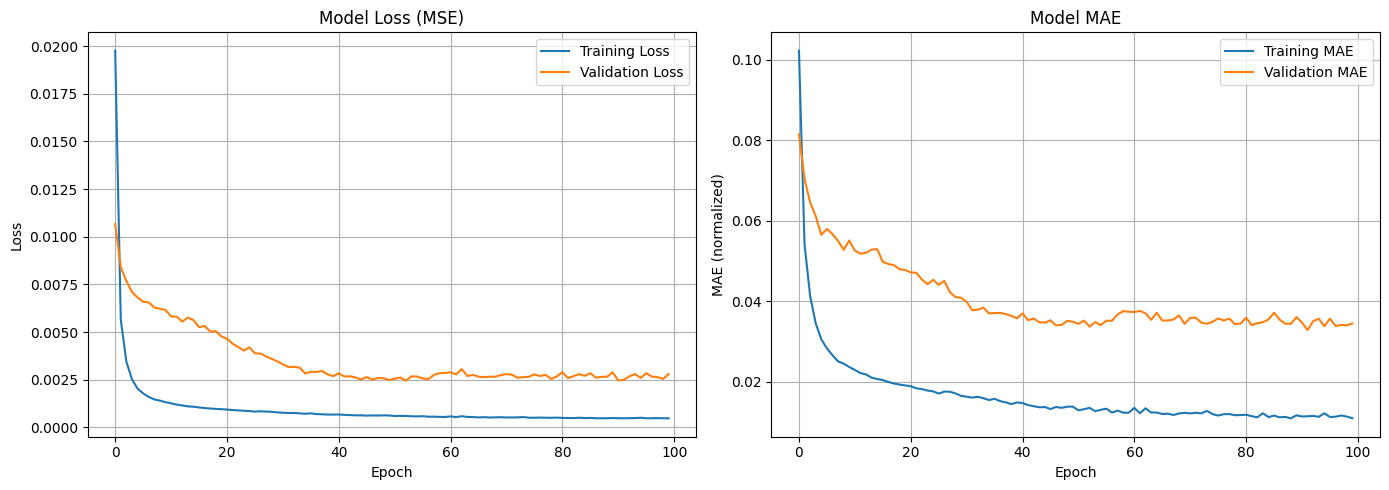

In [26]:
# 4. VISUALIZZA ANDAMENTO TRAINING
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(h_multi.history['loss'], label='Training Loss')
plt.plot(h_multi.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(h_multi.history['mae'], label='Training MAE')
plt.plot(h_multi.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step


PV - MAE: 0.271 kW, R²: 0.730
Load - MAE: 0.418 kW, R²: 0.481


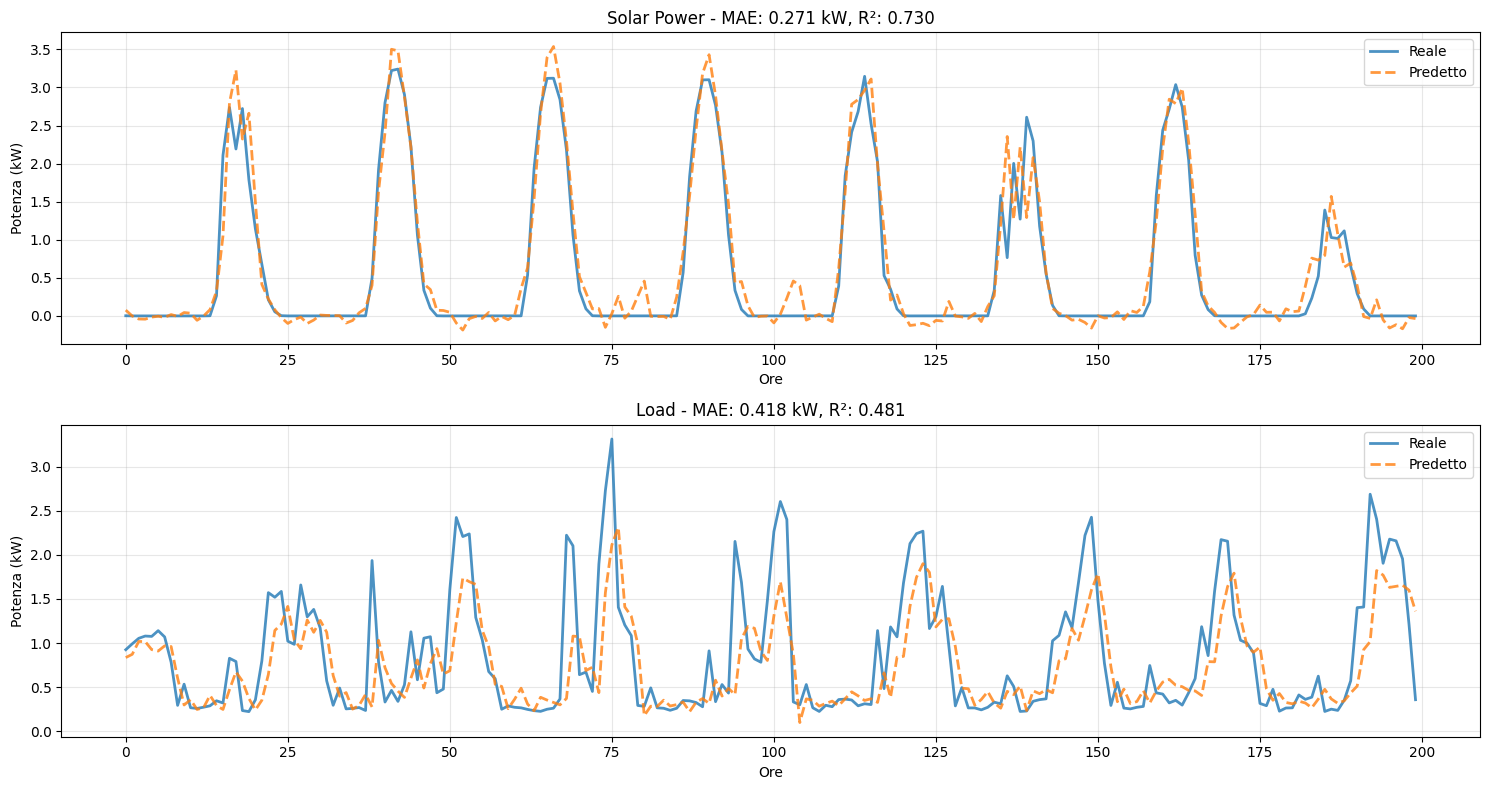

In [27]:
# 5. TEST GRAFICO - Confronto predizioni vs reali
from sklearn.metrics import mean_absolute_error, r2_score

# Predizioni su tutto il test set
pred_test = model_multi.predict(X_test) * MAX_POWER
real_test = y_test * MAX_POWER

# Calcola metriche
mae_pv = mean_absolute_error(real_test[:,0], pred_test[:,0])
mae_load = mean_absolute_error(real_test[:,1], pred_test[:,1])
r2_pv = r2_score(real_test[:,0], pred_test[:,0])
r2_load = r2_score(real_test[:,1], pred_test[:,1])

print(f"PV - MAE: {mae_pv:.3f} kW, R²: {r2_pv:.3f}")
print(f"Load - MAE: {mae_load:.3f} kW, R²: {r2_load:.3f}")

# Visualizzazione (prime 200 ore del test set)
steps = min(200, len(X_test))

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Solar Power
axes[0].plot(real_test[:steps,0], label='Reale', linewidth=2, alpha=0.8)
axes[0].plot(pred_test[:steps,0], label='Predetto', linestyle='--', linewidth=2, alpha=0.8)
axes[0].set_title(f"Solar Power - MAE: {mae_pv:.3f} kW, R²: {r2_pv:.3f}")
axes[0].set_xlabel("Ore")
axes[0].set_ylabel("Potenza (kW)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Load
axes[1].plot(real_test[:steps,1], label='Reale', linewidth=2, alpha=0.8)
axes[1].plot(pred_test[:steps,1], label='Predetto', linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_title(f"Load - MAE: {mae_load:.3f} kW, R²: {r2_load:.3f}")
axes[1].set_xlabel("Ore")
axes[1].set_ylabel("Potenza (kW)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# 6. ESPORTAZIONE C (emlearn)

cmodel_multi = emlearn.convert(model_multi, method='inline')
cmodel_multi.save(file="power_predictor_model.h", name='power_predictor')

print("Modello multi-output esportato con successo!")
print(f"Parametri C da usare:\n#define MAX_POWER {MAX_POWER}\n#define MAX_IRR {MAX_IRR}")

Modello multi-output esportato con successo!
Parametri C da usare:
#define MAX_POWER 10.0
#define MAX_IRR 1200.0
